In [2]:
#Adım 1: Gerekli Kütüphanelerin İçe Aktarılması
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from wordcloud import WordCloud
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [3]:
#Adım 2: Veri Yükleme ve Temizlik
# IPL_2021_tweets.csv dosyasını okur, geçersiz satırları atlar ve bir pandas DataFrame oluşturur.
df = pd.read_csv('IPL_2021_tweets.csv', on_bad_lines='skip', engine='python')

# df DataFrame'inin bir yedeğini oluşturur, böylece orijinal veri kaybolmaz.
df_backup = df.copy()

# Boş (NaN) değerleri içeren satırları DataFrame'den atar.
df = df.dropna()

# Veri boyutunu kontrol et
df.shape

(150225, 13)

In [4]:
#Adım 3: Metin İşleme
# 'text' ve 'hashtags' sütunlarını seçer.
df = df[['text']]

# 'text' sütunundaki metni küçük harflere dönüştürür.
df['text'] = df['text'].str.lower()

# Stopwords çıkarma: Metinden önemsiz kelimeleri çıkarır.
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Noktalama işaretleri, URL ve mention'ları temizler.
df['text'] = df['text'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x))  # URL'leri kaldırır.
df['text'] = df['text'].apply(lambda x: re.sub(r'@\w+', '', x))  # Mention'ları kaldırır.
df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))  # Sadece harfleri bırakır.

# Lemmatization işlemi ile kelimeleri köklerine indirger.
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
df['text'] = df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\safa1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\safa1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\safa1\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [5]:
# İlk 999999 satırı görüntüler.
df.head(999999)

,text
0,notable exclusion ipl previously one le list p...
2,england st inning lead already stump day james...
3,kiwi ipl crew rejigged comp chennai mitchell s...
4,adil rashid play ipl signing punjab king ipl
5,saw united color benetton men flipflops house ...
...,...
252389,maxwell sold rcb cr iplauction maxwell
252391,iplauction maxwell cr know auction cab irratio...
252392,well played csk purposely pushing price reduce...
252395,omg kedharjadhav unsold iplauction


In [6]:
#Adım 4: TF-IDF Vektörleştirme
# TF-IDF Vektörleştirici oluşturma
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2), min_df=5, max_df=0.8)

# Metin verisini vektörleştirme
X = vectorizer.fit_transform(df['text'])

# Vektörlerin DataFrame'e dönüştürülmesi
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())


In [7]:
#Adım 5: K-Means Kümeleme
# K-Means Kümeleme Modelini Eğitmek
k = 5  # Küme sayısını belirle
kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
kmeans.fit(X)

# Küme etiketlerini veri setine ekle
df['cluster'] = kmeans.labels_


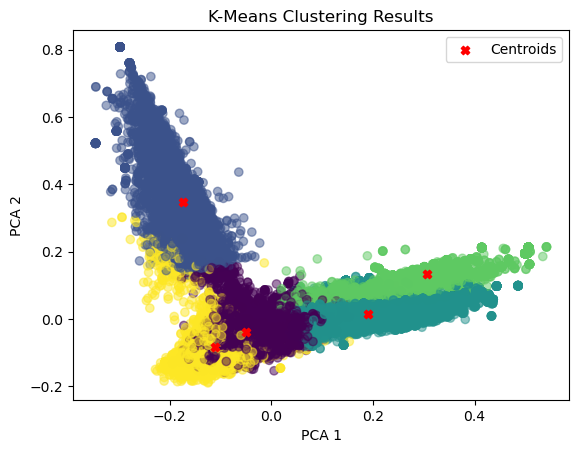

In [8]:
#Adım 6: Küme Merkezlerini Görselleştirme
# Küme merkezlerini görselleştirmek için PCA ile 2D'ye indirgeme
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())
centroids_pca = pca.transform(kmeans.cluster_centers_)

# Kümeleme sonuçlarını görselleştirme
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='X', label='Centroids')
plt.title("K-Means Clustering Results")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.show()


theme
#MatchSummary    93500
#FanReactions    33353
#IPL2021         13301
#Sponsorship     10071
Name: count, dtype: int64


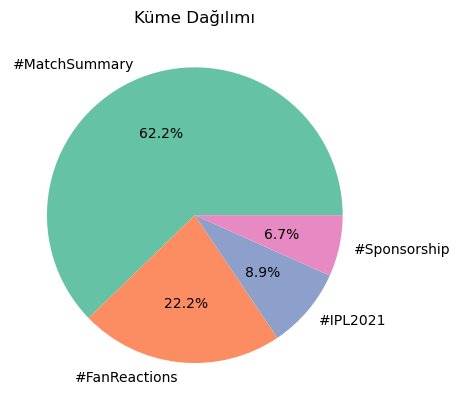

In [9]:
#Adım 7: Küme Etiketlerini İsimlendirme
# Küme etiketlerine anlamlı isimler atama
cluster_labels = {
    0: "#MatchSummary",
    1: "#Sponsorship",
    2: "#FanReactions",
    3: "#MatchSummary",
    4: "#IPL2021"
}

# Küme etiketlerini veriye ekle
df['theme'] = df['cluster'].map(cluster_labels)

# Küme temalarına göre veri sayısını görüntüle
print(df['theme'].value_counts())

# Küme dağılımını görselleştirme
df['theme'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854'])
plt.title("Küme Dağılımı")
plt.ylabel("")
plt.show()


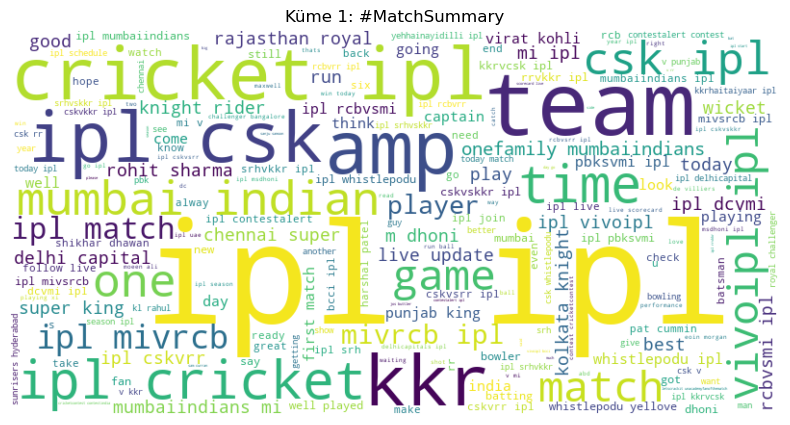

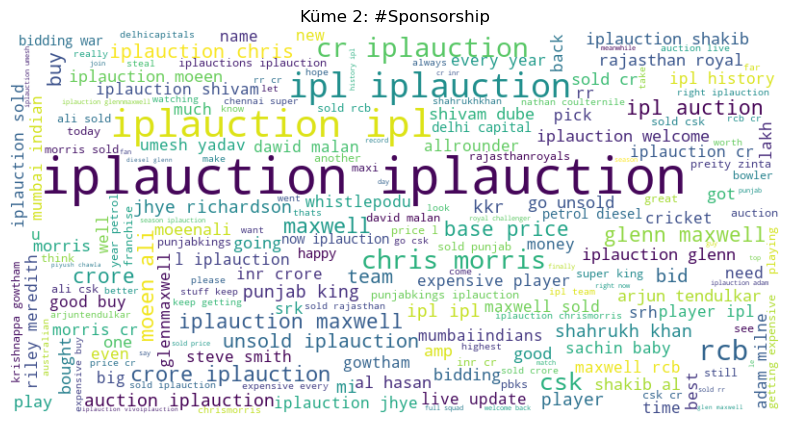

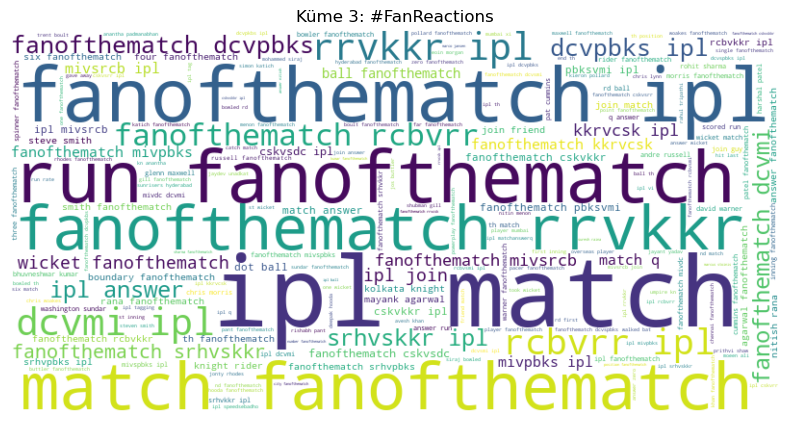

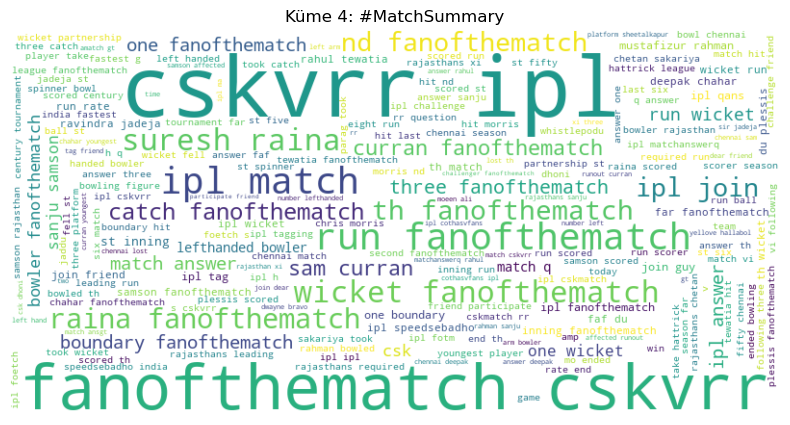

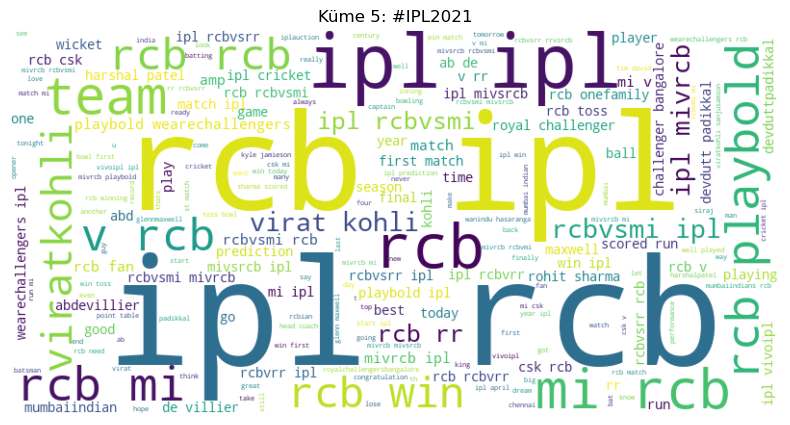

In [10]:
#Adım 8: Kelime Bulutu Görselleştirmesi
# Kelime bulutu görselleştirmesi
for i in range(k):
    plt.figure(figsize=(10, 5))
    cluster_text = ' '.join(df[df['cluster'] == i]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Küme {i+1}: {cluster_labels[i]}")
    plt.axis('off')
    plt.show()

In [11]:
# Davies-Bouldin Skoru
davies_bouldin = davies_bouldin_score(X.toarray(), kmeans.labels_)
print(f"Davies-Bouldin Skoru: {davies_bouldin:.4f}")

Davies-Bouldin Skoru: 5.5205


In [12]:
# Inertia (WCSS) Değeri
print(f"Inertia (WCSS): {kmeans.inertia_:.4f}")

Inertia (WCSS): 140224.4917


In [13]:
#Adım 9: Kümeleme Değerlendirme Metrikleri
# Silhouette Skoru
silhouette_avg = silhouette_score(X, kmeans.labels_)
print(f"Silhouette Skoru: {silhouette_avg:.4f}")

Silhouette Skoru: 0.0204
